# KAN-ODE

In [17]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import pandas as pd
from base_kan.ekan import EKAN  

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = []  

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S,I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  #
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

In [ ]:
gamma = 0.07
beta = 2 * gamma  #
neural_ode_func = EKAN(layers_hidden=[2, 64, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  
last= 120.    
step = 120   
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  #
t = torch.linspace(intial, last, step) 

In [22]:
def get_data():
    gamma = 0.07
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    def sir(t, y):
        S, I, R, A= y
        dS_dt = -beta * S * I
        dI_dt = beta * S * I - gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [23]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

In [24]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [25]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(5000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [26]:
t, true_y, pred_y, neural_outputs = train()

Iter 0, Loss: 2.2110321521759033, Accuracy: 0.83%
Iter 100, Loss: 0.058084554970264435, Accuracy: 3.33%
Iter 200, Loss: 0.04325596243143082, Accuracy: 3.33%
Iter 300, Loss: 0.02285650558769703, Accuracy: 3.33%
Iter 400, Loss: 0.003813378047198057, Accuracy: 6.67%
Iter 500, Loss: 0.00025129641289822757, Accuracy: 35.83%
Iter 600, Loss: 7.827580702723935e-05, Accuracy: 60.83%
Iter 700, Loss: 6.207000114955008e-05, Accuracy: 74.17%
Iter 800, Loss: 5.2190767746651545e-05, Accuracy: 94.17%
Iter 900, Loss: 4.3552896386245266e-05, Accuracy: 95.00%
Iter 1000, Loss: 3.595405723899603e-05, Accuracy: 95.00%
Iter 1100, Loss: 2.9428445486701094e-05, Accuracy: 95.83%
Iter 1200, Loss: 2.396001036686357e-05, Accuracy: 96.67%
Iter 1300, Loss: 1.9497787434374914e-05, Accuracy: 97.50%
Iter 1400, Loss: 1.594887908140663e-05, Accuracy: 98.33%
Iter 1500, Loss: 1.3210226825322025e-05, Accuracy: 99.17%
Iter 1600, Loss: 1.1157788321725093e-05, Accuracy: 100.00%
Iter 1700, Loss: 9.673266504250932e-06, Accuracy:

In [ ]:
def forword_CF(x):
 
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    

    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
    
    result = x.clone().detach()
    
    result[1:] = x[1:] - x[:-1]
    
    return result

In [28]:
true_y[:,3] = forword_CF(true_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_739391/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [29]:
data = {
    'Time': t.numpy(),
    'True_S': true_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': true_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': true_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': true_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],
}
df = pd.DataFrame(data)


In [30]:
df.to_excel('result/KAN/kan2-64-1.xlsx', index=False)

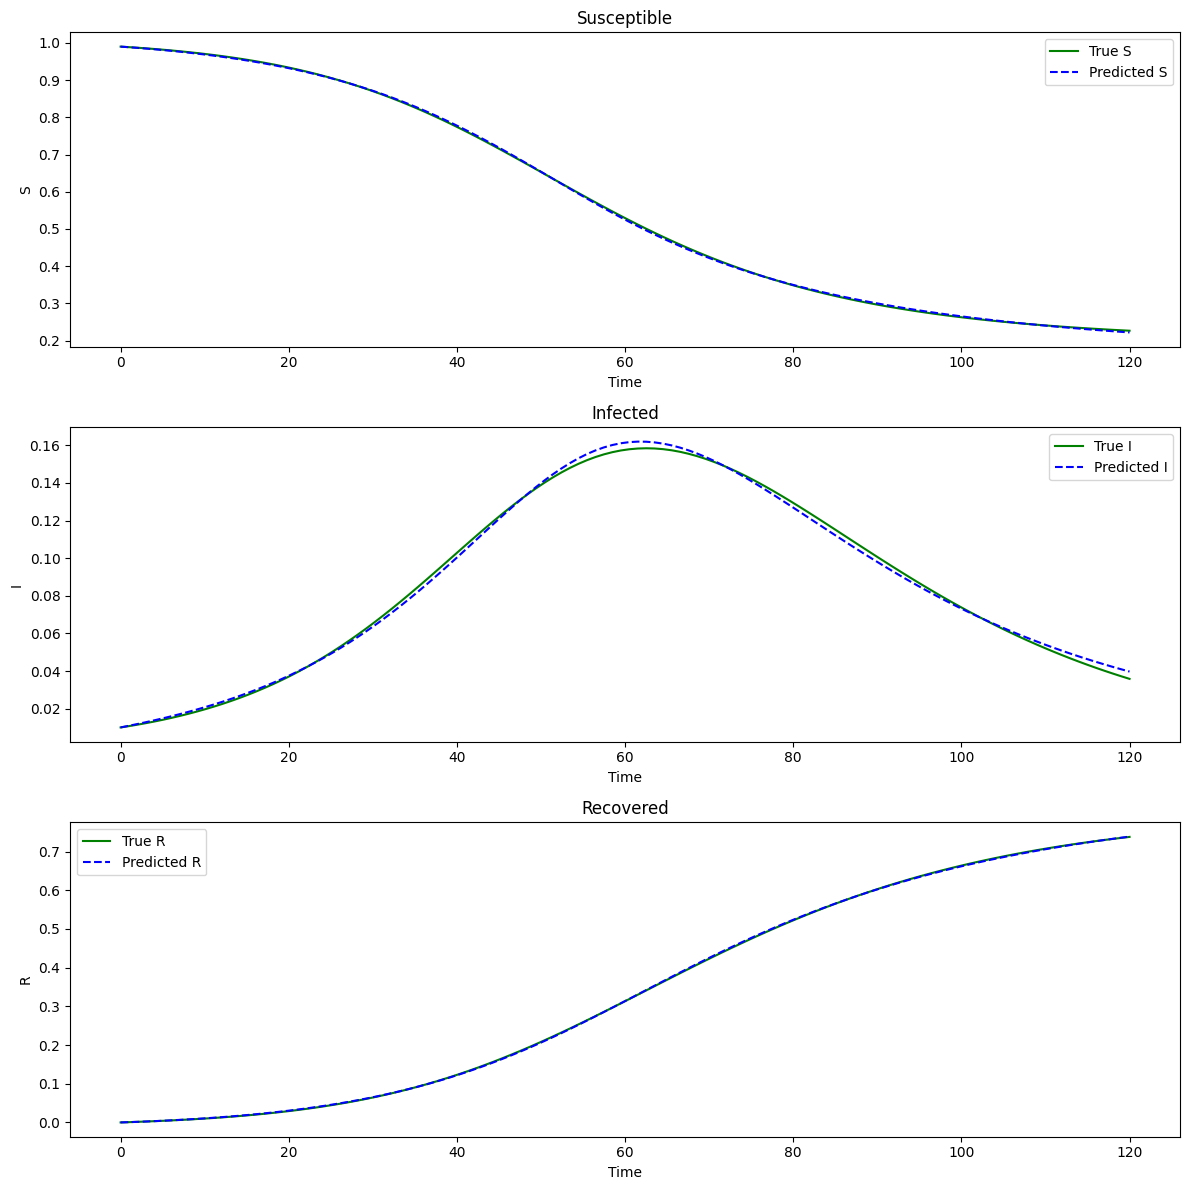

In [31]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), true_y.numpy()[:, 0], 'g-', label='True S')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], 'b--', label='Predicted S')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), true_y.numpy()[:, 1], 'g-', label='True I')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], 'b--', label='Predicted I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), true_y.numpy()[:, 2], 'g-', label='True R')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], 'b--', label='Predicted R')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.savefig('picture/KAN/kan2-64-1_SIR.png')
plt.show()


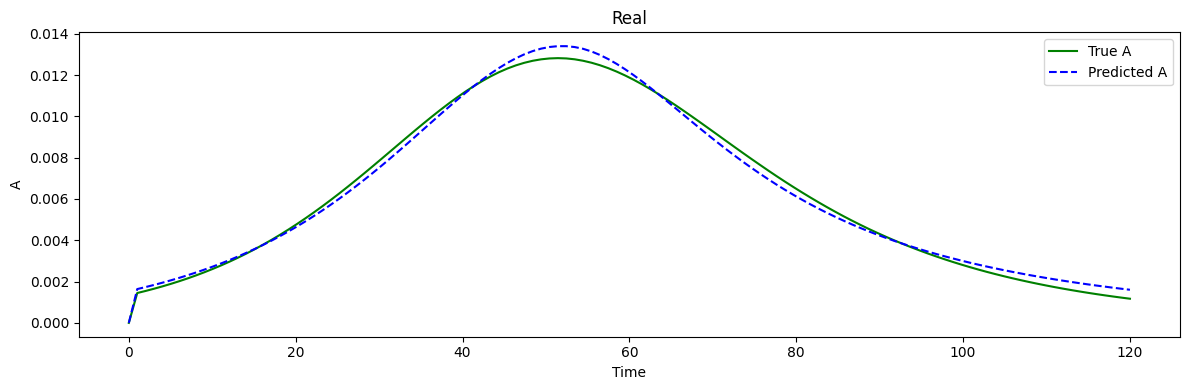

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(t.numpy(), true_y.numpy()[:, 3], 'g-', label='True A')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], 'b--', label='Predicted A')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')

plt.tight_layout()
plt.savefig('picture/KAN/kan2-64-1_true.png')
plt.show()